# PCB Components Detection and Classification

This notebook demonstrates an end-to-end pipeline for automatic detection and classification of PCB (Printed Circuit Board) components from high-resolution images using computer vision and deep learning techniques. 
<br/>
The workflow includes:
- Image preprocessing
- Contour detection
- Template matching
- Deep learning-based object detection 
<br/>
with a focus on scalability for real-time industrial inspection.

## 1. Import Required Libraries

Import essential libraries for image processing, visualization, and deep learning. 
<br/>
We use:
- OpenCV and NumPy for computer vision tasks
- Matplotlib for visualization
- Ultralytics YOLO for deep learning-based object detection.

In [ ]:
# Install required libraries (run this cell)

# %pip install opencv-contrib-python numpy pandas matplotlib ultralytics

In [2]:
# Import libraries
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Visualize PCB Image

Load a high-resolution PCB image and display it for initial inspection. Replace the image path with your own PCB image as needed.

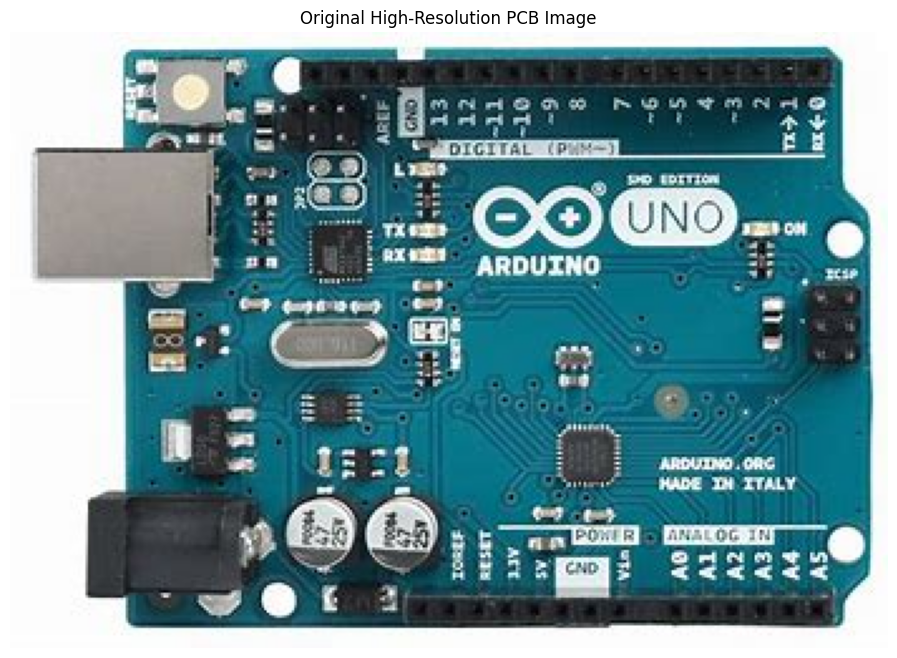

In [3]:
# Load and visualize PCB image
pcb_image_path = 'uno.png'  # Replace with your image path

# Read image using OpenCV
image = cv2.imread(pcb_image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {pcb_image_path}")

# Convert BGR (OpenCV default) to RGB for visualization
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.title('Original High-Resolution PCB Image')
plt.axis('off')
plt.show()

## 3. Image Preprocessing

Apply preprocessing steps such as:
- Resizing
- Grayscale Conversion
- Noise Reduction
- Contrast Enhancement 
<br/> to prepare the image for analysis.

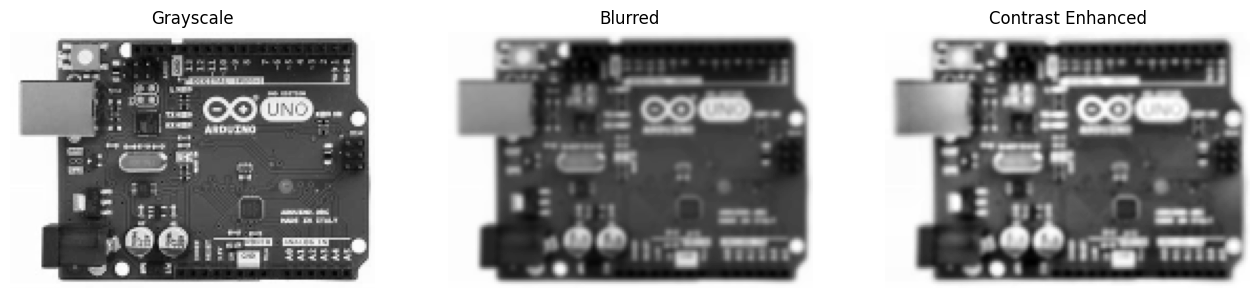

In [3]:
# Image Preprocessing
# Resize for faster processing (optional, depending on image size)
resized = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)

# Convert to grayscale
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

# Noise reduction using Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Contrast enhancement using CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(blurred)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(enhanced, cmap='gray')
plt.title('Contrast Enhanced')
plt.axis('off')
plt.show()

## 4. Contour Detection and Segmentation

Detect contours to segment potential component regions from the PCB image using OpenCV.

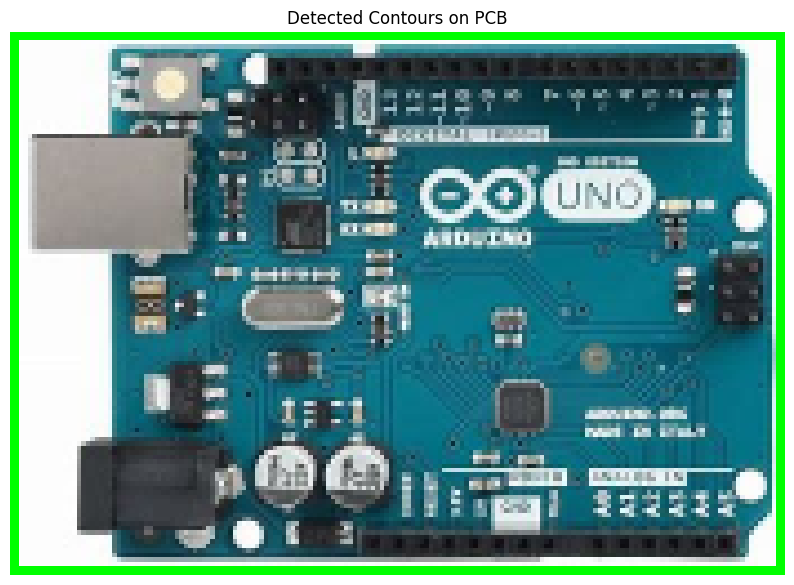

Number of contours detected: 1


In [4]:
# Contour Detection and Segmentation
# Thresholding to create binary image
_, thresh = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the image
contour_img = resized.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title('Detected Contours on PCB')
plt.axis('off')
plt.show()

print(f"Number of contours detected: {len(contours)}")

## 5. Template Matching for Component Identification

Apply template matching to identify standard components such as resistors, capacitors, and diodes. You need to provide template images for each component type.

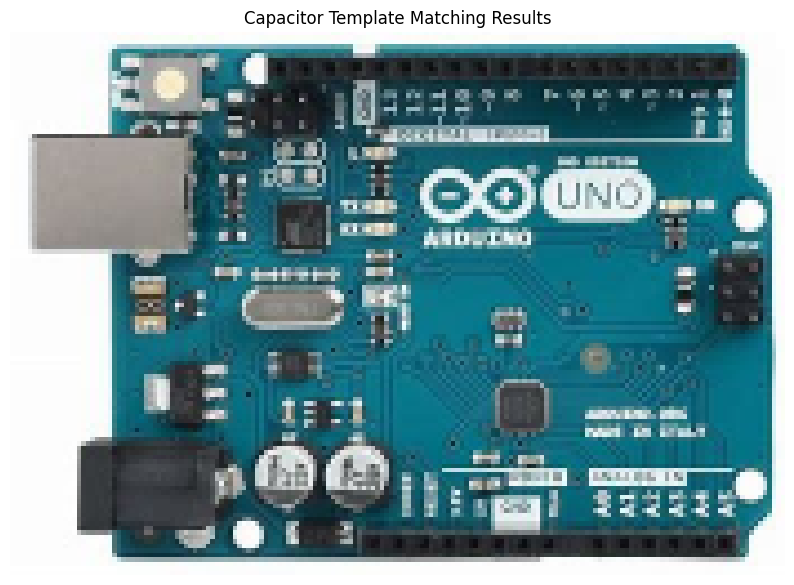

In [7]:
# Template Matching for Component Identification
# Example: Matching a capacitor template

template_path = 'capacitor_template.png'  # Replace with your template path
template = cv2.imread(template_path, 0)
if template is None:
    print("Capacitor template not found. Skipping template matching.")
else:
    h, w = template.shape[:2]
    cap = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.7
    loc = np.where(cap >= threshold)

    matched_img = resized.copy()
    for pt in zip(*loc[::-1]):
        cv2.rectangle(matched_img, pt, (pt[0] + w, pt[1] + h), (255, 0, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title('Capacitor Template Matching Results')
    plt.axis('off')
    plt.show()

## 6. Numpy Logic for Component Identification

Apply Numerical Operation to identify standard components such as resistors, capacitors, and diodes. 

In [8]:
# 📷 Advanced Real-Time PCB Component Detection using OpenCV

import cv2
import numpy as np


In [9]:

# Preprocessing function to enhance image quality
def preprocess(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), 0) # Apply Gaussian blur
    edges = cv2.Canny(blurred, 30, 120) # Edge detection
    # Morphological operations to close gaps in edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) 
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel) 
    dilated = cv2.dilate(closed, kernel, iterations=2)
    return dilated


In [10]:

# Feature extraction function to analyze regions of interest (ROIs)
def extract_features(roi):
    mean_color = cv2.mean(roi)[:3] # Get mean color in BGR format
    h, w, _ = roi.shape  # Height and width of the ROI
    area = w * h  # Calculate area of the ROI
    # Calculate aspect ratio
    aspect_ratio = w / float(h)
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) # Convert ROI to grayscale
    # Thresholding to create binary image
    _, binary = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    white_px = cv2.countNonZero(binary) # Count white pixels
    # Calculate black pixels
    black_px = area - white_px
    # Calculate ratio of white pixels to total area
    white_ratio = white_px / area if area > 0 else 0 
    return [*mean_color, area, aspect_ratio, white_ratio]

In [11]:
# Function to classify components based on extracted features
def classify_component(features):
    _, g, _, area, ratio, white_ratio = features
    # More refined rules, can be replaced with ML model
    if area < 300:
        return "Noise"
    elif 300 <= area <= 1000:
        if ratio > 2.5:
            return "Resistor"
        elif white_ratio > 0.7:
            return "LED"
        else:
            return "Small Cap."
    elif 1000 < area <= 3000:
        if ratio < 1.3:
            return "Capacitor"
        elif white_ratio > 0.7:
            return "Connector"
        else:
            return "Medium IC"
    elif area > 3000:
        if ratio > 1.1:
            return "IC"
        elif white_ratio > 0.7:
            return "Socket"
        else:
            return "Large Comp."
    return "Unknown"


In [13]:
# Function to draw contour information on the output image
def draw_contour_info(output, x, y, w, h, label, features):
    color_map = {
        "Resistor": (0, 255, 255), # Yellow
        "Capacitor": (255, 0, 255), # Magenta
        "IC": (0, 255, 0), # Green
        "LED": (0, 128, 255), # Orange
        "Connector": (255, 128, 0), # Cyan
        "Socket": (128, 0, 255), # Purple
        "Small Cap.": (255, 255, 0), # Light Blue
        "Medium IC": (0, 255, 128), # Light Green
        "Large Comp.": (128, 255, 0), # Light Yellow    
        "Noise": (128, 128, 128), # Gray
        "Unknown": (0, 0, 255) # Red
    }
    color = color_map.get(label, (0, 0, 255)) # Default to red for unknown
    cv2.rectangle(output, (x, y), (x+w, y+h), color, 2) # Draw rectangle around contour
    # Draw label above rectangle
    cv2.putText(output, label, (x, y-8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    # Show area and aspect ratio for debugging
    area = int(features[3])
    ratio = round(features[4], 2)
    # Display area and ratio below the rectangle
    cv2.putText(output, 
                f"A:{area} R:{ratio}", (x, y+h+15), cv2.FONT_HERSHEY_PLAIN, 0.7, color, 1)


In [14]:
# Real-time Component Detection using OpenCV
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    processed = preprocess(frame)
    contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = frame.copy()

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)  
        if w > 10 and h > 10:
            roi = frame[y:y+h, x:x+w]
            features = extract_features(roi)
            label = classify_component(features)
            draw_contour_info(output, x, y, w, h, label, features)

    # Add legend
    legend_y = 25
    for name, color in [
        ("Resistor", (0,255,255)), ("Capacitor", (255,0,255)), ("IC", (0,255,0)),
        ("LED", (0,128,255)), ("Connector", (255,128,0)), ("Socket", (128,0,255)),
        ("Noise", (128,128,128)), ("Unknown", (0,0,255))
    ]:
        cv2.rectangle(output, (10, legend_y-10), (30, legend_y+10), color, -1)
        cv2.putText(output, name, (35, legend_y+5), cv2.FONT_HERSHEY_PLAIN, 1, 
                    (255,255,255), 1)
        legend_y += 25

    cv2.putText(output, "Press 'q' to quit", (10, output.shape[0]-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)
    cv2.imshow("Advanced Real-Time Component Detection", output)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## 7. Deep Learning-Based Object Detection

Use a pre-trained or custom-trained deep learning model (e.g., YOLOv8) to detect and classify PCB components. For demonstration, we use a pre-trained YOLOv8 model via Ultralytics.

In [7]:
'''
# Remove Triple Quotes to Enable YOLOv8 Training (''' ''')
# Load a YOLOv8 model (choose 'yolov8n.pt', 'yolov8s.pt', etc.)
model = YOLO('yolov8n.pt')

# Train the model
model.train(
    data='dataset/data.yaml',  # path to your data.yaml
    epochs=5,                 # number of training epochs
    imgsz=640,                 # image size
    batch=8                    # batch size
)
'''

"\n# Remove Triple Quotes to Enable YOLOv8 Training ()\n# Load a YOLOv8 model (choose 'yolov8n.pt', 'yolov8s.pt', etc.)\nmodel = YOLO('yolov8n.pt')\n\n# Train the model\nmodel.train(\n    data='dataset/data.yaml',  # path to your data.yaml\n    epochs=5,                 # number of training epochs\n    imgsz=640,                 # image size\n    batch=8                    # batch size\n)\n"

## 8. Annotate Detected Components

Draw bounding boxes and labels on the image for each detected component using the deep learning model's output.

In [4]:
# Load your trained model
model = YOLO('best.pt')

# Inference on an image
results = model('uno.png') # Replace with your image path
results[0].show()


image 1/1 c:\Users\minus\OneDrive\Documents\Internships\OCAC\ProjectFiles\PCB-Components-Identification\PCB-DETECTIONv4\uno.png: 480x640 10 Capacitors, 6 ICs, 1 LED, 3 Resistors, 3 connectors, 6 transistors, 268.9ms
Speed: 12.9ms preprocess, 268.9ms inference, 21.3ms postprocess per image at shape (1, 3, 480, 640)


## 9. Evaluate Detection Accuracy

Calculate metrics such as precision, recall, and F1-score to evaluate the detection and classification performance.

In [8]:
# Load the results.csv file from the specified path
df = pd.read_csv("runs/detect/train/results.csv")

# Display the rows as cell output
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3891.63,1.54188,2.78041,1.29457,0.27581,0.18103,0.15472,0.10006,1.46581,2.29562,1.49823,0.000237,0.000237,0.000237
1,2,7519.81,1.47879,1.94560,1.24257,0.30420,0.22404,0.19883,0.12342,1.34908,2.07077,1.39822,0.000381,0.000381,0.000381
2,3,10243.10,1.45353,1.72829,1.20496,0.44012,0.28453,0.28242,0.17684,1.36057,1.63438,1.37423,0.000431,0.000431,0.000431
3,4,13169.30,1.38111,1.52445,1.17060,0.44111,0.34365,0.32860,0.19842,1.28480,1.54365,1.30495,0.000290,0.000290,0.000290
4,5,16303.80,1.35855,1.42148,1.15808,0.62279,0.36488,0.39776,0.24895,1.25604,1.35085,1.25368,0.000149,0.000149,0.000149


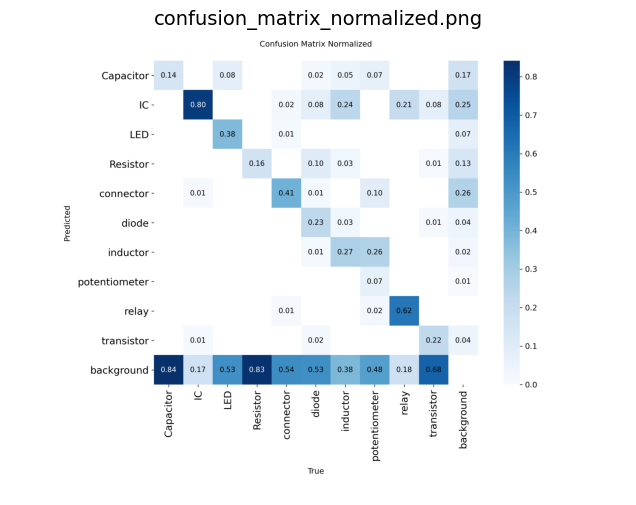

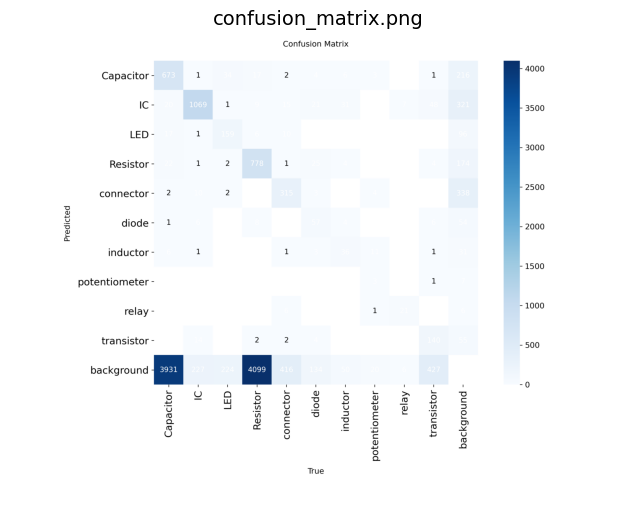

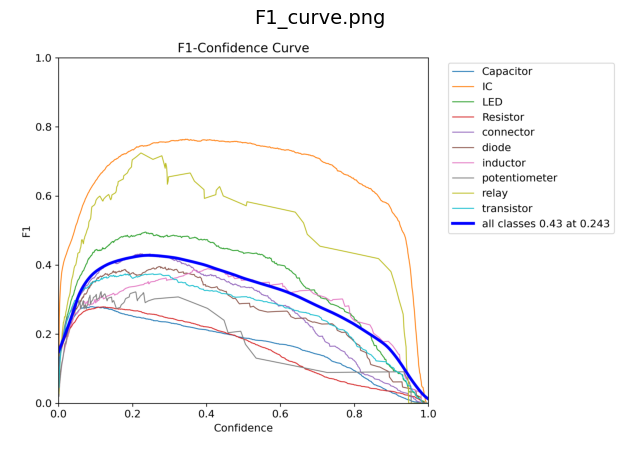

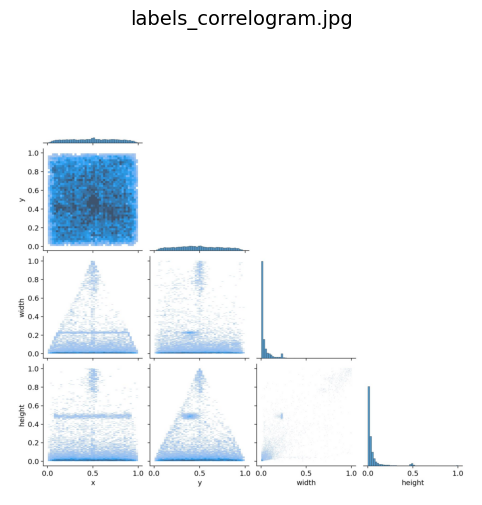

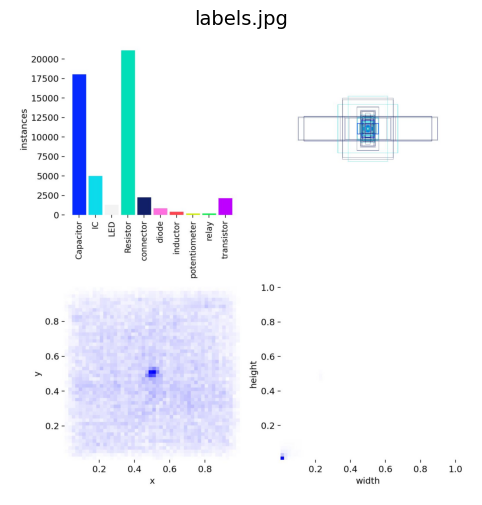

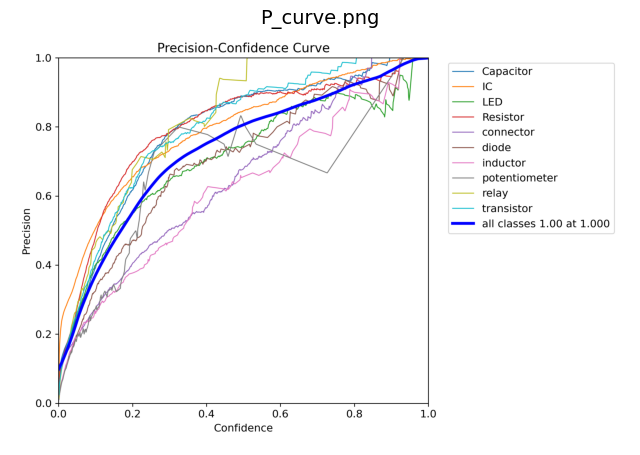

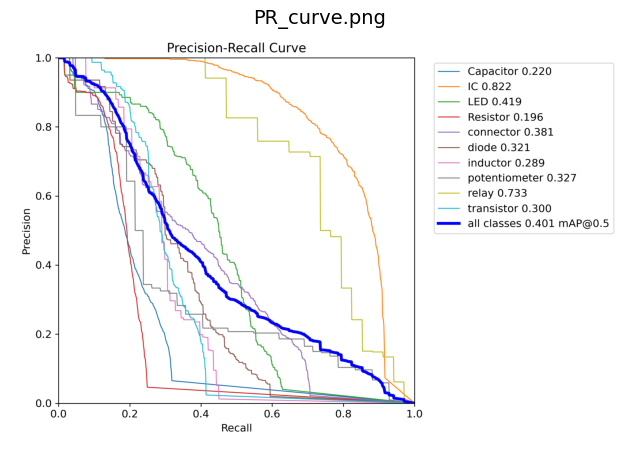

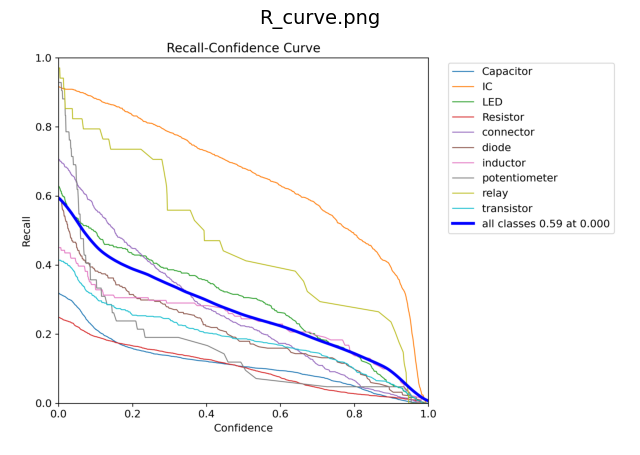

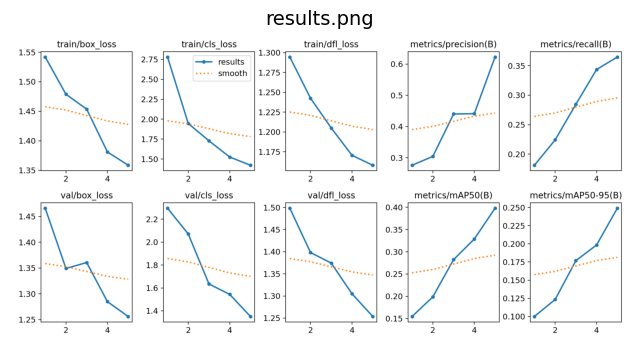

In [17]:
# Ordered list of result images for presentation from runs/detect/train2
image_files = [
    "confusion_matrix_normalized.png",
    "confusion_matrix.png",
    "F1_curve.png",
    "labels_correlogram.jpg",
    "labels.jpg",
    "P_curve.png",
    "PR_curve.png",
    "R_curve.png",
    "results.png"    
]

base_path = "runs/detect/train2"

for fname in image_files:
    img_path = f"{base_path}/{fname}"
    img = cv2.imread(img_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.title(fname, fontsize=14)
        plt.axis('off')
        plt.show()
    else:
        print(f"Could not load {img_path}")

## 10. Scalability for Real-Time Inspection

Discuss and demonstrate code optimizations or batching for real-time or near real-time PCB inspection scenarios.

In [ ]:
# Real-time detection using YOLOv8

# Load your trained model
model = YOLO('runs/detect/train2/weights/best.pt') 
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)[0]
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = model.names[int(box.cls[0])]
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    cv2.imshow("YOLOv8 PCB Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Conclusion
This notebook provides a modular pipeline for PCB component detection and classification using both traditional computer vision and deep learning methods. For industrial deployment, further improvements such as large scale custom model training, dataset annotation, and hardware optimization are recommended.

# For Streamlit Deployment
Create:
- "requirements.txt" file for listing Dependencies
- "app.py" file for Deployment Code

<br/>
Install dependencies:

```bash
pip install -r requirements.txt
```
<br/>
Run using following command: <br/>

```bash
python -m streamlit run app.py
```
<br/>
Or simply <br/>

```bash
streamlit run app.py
```

# requirements.txt

```bash
streamlit
opencv-python
numpy
matplotlib
ultralytics
pandas
```

# app.py

```python
import streamlit as st
import cv2
from ultralytics import YOLO
import numpy as np

st.title("YOLOv8 PCB Component Detection")

# Load model once
@st.cache_resource
def load_model():
    return YOLO('runs/detect/train2/weights/best.pt')

model = load_model()

# Webcam or image upload
option = st.radio("Choose input source:", ("Webcam", "Image Upload"))

if option == "Webcam":
    run = st.checkbox('Start Webcam')
    FRAME_WINDOW = st.image([])
    cap = None

    if run:
        cap = cv2.VideoCapture(0)
        while run:
            ret, frame = cap.read()
            if not ret:
                st.warning("Failed to grab frame")
                break
            results = model(frame)[0]
            for box in results.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                label = model.names[int(box.cls[0])]
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
            FRAME_WINDOW.image(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if cap:
            cap.release()
else:
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])
    if uploaded_file is not None:
        file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
        img = cv2.imdecode(file_bytes, 1)
        results = model(img)[0]
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = model.names[int(box.cls[0])]
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
        st.image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), caption="Detected Components", use_column_width=True)
```